In [51]:
import os
from typing import Dict, NamedTuple, Union, List, Tuple
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
class Config(NamedTuple):
    data_l: str = "../2way_anova_landscape.csv"
    data_p: str = "../2way_anova_portrait.csv"
    dirctory: str = "../images/mla"
    savefile: bool = False
    kwarg_savefig: Dict[str, Union[str, int, float]] = {
        "facecolor": "white",
        "dpi": 300,
        "bbox_inches": "tight",
        "pad_inches": 0.05
    }

In [3]:
conf = Config(savefile=True)

In [4]:
os.makedirs(conf.dirctory, exist_ok=True)

In [5]:
def power(
    data: pd.core.frame.DataFrame, 
    dim: int,
    subtract_scale: bool = True,
    name_digit: int = 3
    ) -> pd.core.frame.DataFrame:

    assert isinstance(dim, int) and dim >= 1, \
        f"dim expected non-zero positive int; got {dim}"
    assert isinstance(name_digit, int) and name_digit >= 0, \
        f"name_digit expected positive int; got {name_digit}"

    ret = pd.DataFrame(index=data.index)

    for i in range(dim):
        temp = data ** (i + 1) if not subtract_scale \
            else (data - data.mean()) ** (i + 1)
        if subtract_scale:
            temp.columns = [
                f"({name}-{data.mean()[j].round(name_digit)})" + \
                    f"*({name}-{data.mean()[j].round(name_digit)})" * (i) for j, name in enumerate(temp.columns)
                ]
        else:
            temp.columns = [
                f"{name}" + f"*{name}" * (i) for name in temp.columns
                ]
        ret = pd.concat([ret, temp], axis=1)
    
    return ret

def interaction(
    data: pd.core.frame.DataFrame, 
    dim: int,
    subtract_scale: bool = True,
    name_digit: int = 3
    ) -> pd.core.frame.DataFrame:

    assert isinstance(dim, int) and dim >= 1, \
        f"dim expected non-zero positive int; got {dim}"
    assert isinstance(name_digit, int) and name_digit >= 0, \
        f"name_digit expected positive int; got {name_digit}"
    assert data.shape[1] >= dim, \
        f"""
        dim expected <= data.shape[1];
        got 
        dim: {dim}
        shape of data: {data.shape}

        if you want to have interactions of features ** n,
        use power() method ahead of this process
        """
    
    temp = data.copy()
    ret = pd.DataFrame(index=temp.index)
    temp.columns = data.columns if not subtract_scale \
        else [f"({name}-{data.mean()[i].round(name_digit)})" for i, name in enumerate(data.columns)]

    for i in range(dim):
        l_comb = list(combinations(temp.columns, i + 1))
        l_df_comb = [ret] + [
            pd.DataFrame(
                temp.loc[:, list(comb)].cumprod(axis=1).iloc[:, -1].values,
                index = temp.index,
                columns = ["*".join(comb)]
            ) for comb in l_comb
            ]
        ret = pd.concat(l_df_comb, axis=1)
    return ret

def feat_selector(data: pd.core.frame.DataFrame) -> List[pd.core.frame.DataFrame]:
    ret = []
    for i in range(len(data)):
        l_comb = list(combinations(data.columns, i + 1))
        ret += [data.loc[:, list(comb)] for comb in l_comb]
    return ret

In [6]:
# load result data

res_l = pd.read_csv(conf.data_l, index_col=0)
res_p = pd.read_csv(conf.data_p, index_col=0)

In [7]:
res_l

,size,n_clip,0,1,2,3,4
0,2.00,0.0,5.94,5.44,6.25,6.32,5.39
1,2.00,2.0,5.41,4.85,4.88,4.78,4.66
2,2.00,4.0,4.09,4.41,3.15,3.84,3.63
3,2.50,0.0,5.75,5.41,6.41,6.09,5.87
4,2.50,2.0,4.94,4.82,4.56,4.48,4.47
5,2.50,4.0,4.68,3.34,3.85,4.00,3.75
6,2.97,0.0,5.65,5.00,5.69,4.46,4.81
7,2.97,2.0,3.69,2.03,3.25,2.44,2.65
8,2.97,4.0,3.63,1.97,3.28,3.68,2.22


In [8]:
x_df = pd.concat(
    [
        power(res_p.iloc[:, 1:], 2, True, 2),
        interaction(res_p.iloc[:, 1:], 2, True, 2)
    ],
    axis=1
)

x_df = x_df.loc[:, ~x_df.columns.duplicated()]

In [9]:
x_df.head()

,(size-2.49),(n_clip-2.0),(size-2.49)*(size-2.49),(n_clip-2.0)*(n_clip-2.0),(size-2.49)*(n_clip-2.0)
0,-0.49,-2.0,0.2401,4.0,0.0
1,-0.49,0.0,0.2401,0.0,4.0
2,-0.49,2.0,0.2401,4.0,8.0
3,0.01,-2.0,0.0001,4.0,0.0
4,0.01,0.0,0.0001,0.0,5.0


In [10]:
df_sep = feat_selector(x_df)

In [11]:
y_df = res_p.time

In [12]:
l_x = [sm.add_constant(x) for x in df_sep]

l_model = [sm.OLS(y_df, x) for x in l_x]
l_result = [model.fit() for model in l_model]
l_aic = [result.aic for result in l_result]

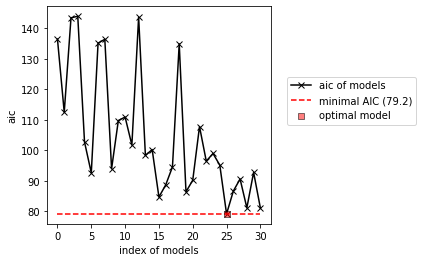

In [79]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(
    np.arange(len(l_aic)),
    l_aic, label="aic of models", c="k", marker="x"
)
ax.plot(
    np.arange(len(l_aic)),
    np.array(l_aic).min() * np.ones(len(l_aic)), linestyle="--",
    c="r", label=f"minimal AIC ({np.array(l_aic).min().round(2)})")

ax.scatter(
    l_aic.index(min(l_aic)), min(l_aic),
    c="r", marker="s", edgecolor="k", zorder=3, alpha=0.5,
    label="optimal model"
)

ax.set(ylabel="aic", xlabel="index of models")

ax.legend(bbox_to_anchor=(1.05, 0.7));

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/aic.png", **conf.kwarg_savefig)

In [14]:
l_result[l_aic.index(min(l_aic))].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     40.00
Date:                Sat, 16 Oct 2021   Prob (F-statistic):           1.78e-13
Time:                        08:10:20   Log-Likelihood:                -34.600
No. Observations:                  45   AIC:                             79.20
Df Residuals:                      40   BIC:                             88.23
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.5262      0.185     24.510      0.000       4.153       4.899
(size-2.49)                  -1.3031      0.209     -6.244      0.000      -1.725      -0.881
(n_clip-2.0)                 -0.5160      0.051    -10.209      0.000      -0.618      -0.414
(size-2.49)*(size-2.49)      -2.5425      0.745     -3.412      0.001      -4.049      -1.036
(n_clip-2.0)*(n_clip-2.0)     0.1182      0.044      2.700      0.010       0.030       0.207
==============================================================================
Omnibus:                        0.492   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.782   Jarque-Bera (JB):                0.634
Skew:                          -0.189   Prob(JB):                        0.728
Kurtosis:                       2.558   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
class variable(NamedTuple):
    name: str
    value: Union[int, float, np.ndarray]

class cubic(NamedTuple):
    x: variable
    y: variable
    z: variable

In [186]:
def get_func(
    params: pd.core.series.Series,
    data: pd.core.frame.DataFrame,
    interval: float = 0.1,
    z_name: str = "Z"
):
    if "const" in params.index:
        idx = params.index[1:]
    else:
        idx = params.index
    
    split_x = lambda l_x: [str(x).split("*") for x in l_x]
    unique = lambda l_x: list(set(l_x))
    get_var = lambda l_x: l_x[0]
    remove_bracket = lambda x: x[1:-1] if "(" in x else x
    split_minus = lambda l_x: [get_var(remove_bracket(x).split("-")) for x in l_x]
    
    l_idx = [split_minus(l_x) for l_x in split_x(idx)]
    l_unique = unique(sum(l_idx, []))

    df_var = data.loc[:, l_unique]
    
    kwd = []
    for v in l_unique:
        kwd += [df_var[v].min(), df_var[v].max()]
    
    xy = np.mgrid[kwd[0]:kwd[1]:interval, kwd[2]:kwd[3]:interval]

    var = {
        v: xy[i] for i, v in enumerate(l_unique)
    }
    mean = {v: df_var[v].mean() for v in l_unique}

    ret = params[0] if "const" in params.index else 0
    for i, l_var in enumerate(l_idx):
        _ret = 1
        for var_name in l_unique:
            _ret *= (var[var_name] - mean[var_name]) ** l_var.count(var_name)
        
        idx_coeff = i + 1 if "const" in params.index else i
        
        ret += params[idx_coeff] * _ret
    
    func = cubic(
        x=variable(name=l_unique[0], value=var[l_unique[0]]),
        y=variable(name=l_unique[1], value=var[l_unique[1]]),
        z=variable(name=z_name, value=ret),
    )
    
    return  func

In [127]:
def contour2d(
    func: cubic,
    ax = None,
    level: int = 10,
    digit: int = 1,
    cmap_fill: str = "bone_r",
    cmap_edge: str = "spring",
    **kwarg
    ):
    if ax is None:
        fig, ax = plt.subplots()
    
    x, y, z = func.x.value, func.y.value, func.z.value
    
    if kwarg == {}:
        kwarg = {
            "xlabel": func.x.name,
            "ylabel": func.y.name,
            "title": func.z.name
        }
    
    fill = ax.contourf(x, y, z, levels=level, cmap=cmap_fill)
    edge = ax.contour(
        x, y, z, levels=level,
        cmap=cmap_edge, zorder=2, alpha=1,
    )
    edge.clabel(fmt=f'%.{digit}f')

    ax.set(**kwarg)

In [154]:
def contour3d(
    func: cubic,
    ax = None,
    level: int = 10,
    cmap: str = "bone_r",
    **kwarg
    ):
    if ax is None:
        fig, ax = plt.subplots(projection="3d")
    
    x, y, z = func.x.value, func.y.value, func.z.value
    
    if kwarg == {}:
        kwarg = {
            "xlabel": func.x.name,
            "ylabel": func.y.name,
            "zlabel": func.z.name,
            "title": func.z.name
        }
    
    ax.plot_surface(
        x, y, z, cmap=cmap, alpha=1,
        ccount=level, rcount=level, lw=0.1
    )
    
    ax.set(**kwarg)

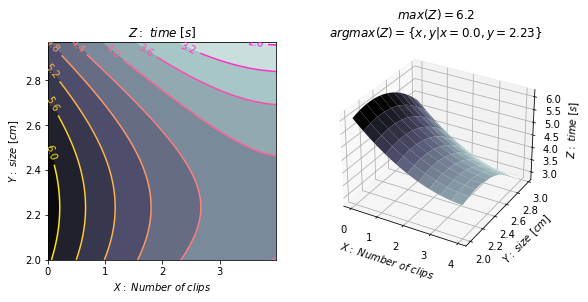

In [189]:
target = l_result[l_aic.index(min(l_aic))].params

func = get_func(target, res_p, interval=0.01, z_name="$time$ $[s]$")

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_subplot(121, facecolor="w")
ax2 = fig.add_subplot(122, projection="3d", facecolor="w")



arg2d = {
    "xlabel": "$X:$ $Number$ $of$ $clips$",
    "ylabel": "$Y:$ $size$ $[cm]$",
    "title": "$Z:$ $time$ $[s]$"
}

v, h = (
    np.argmax(func.z.value) // func.z.value.shape[1],
    np.argmax(func.z.value) % func.z.value.shape[1],
)

title = "$max(Z)=" + f"{func.z.value.max().round(2)}$\n" +\
"$argmax(Z)=\{x, y|" + f"x={func.x.value[v][h].round(2)}," +\
f" y={func.y.value[v][h].round(2)}" + "\}$"

arg3d = {
    "xlabel": "$X:$ $Number$ $of$ $clips$",
    "ylabel": "$Y:$ $size$ $[cm]$",
    "zlabel": "$Z:$ $time$ $[s]$",
    "title": title
}

contour2d(func, ax=ax1, **arg2d)
contour3d(func, ax=ax2, **arg3d)

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/optimization.png", **conf.kwarg_savefig)